# Unsupervised Graded Project

## Goal outcomes:
- Customer Segmentation based on the data provided 

## Problem Statement
Based on the given marketing campigan dataset, segment the similar customers into suitable clusters. Analyze the clusters and provide your insights to help the organization promote their business.

## Context:
- Customer segmentation is one of the most important marketing tools at your disposal, because it can help a business to better understand its target audience.This is because it groups customers based on common characteristics.
- Segmentation can be based on the customer’s habits and lifestyle, in particular, their buying habits. Different age groups, for example, tend to spend their money in different ways, so brands need to be aware of who exactly is buying their product.
- Segmentation also focuses more on the personality of the consumer, including their opinions, interests, reviews, and rating. Breaking down a large customer base into more manageable clusters, making it easier to identify your target audience and launch campaigns and promote the business to the most relevant people

### 1. Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler,LabelEncoder
from scipy import stats
from sklearn.cluster import KMeans
from scipy.stats import zscore
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score

### 2. Load the CSV file (i.e renttherunway.csv) and display the first 5 rows of the dataframe. Check the shape and info of the dataset.

In [2]:
df = pd.read_csv('renttherunway.csv')
df.head()

,Unnamed: 0,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


In [3]:
df.shape

(192544, 16)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      192544 non-null  int64  
 1   fit             192544 non-null  object 
 2   user_id         192544 non-null  int64  
 3   bust size       174133 non-null  object 
 4   item_id         192544 non-null  int64  
 5   weight          162562 non-null  object 
 6   rating          192462 non-null  float64
 7   rented for      192534 non-null  object 
 8   review_text     192482 non-null  object 
 9   body type       177907 non-null  object 
 10  review_summary  192199 non-null  object 
 11  category        192544 non-null  object 
 12  height          191867 non-null  object 
 13  size            192544 non-null  int64  
 14  age             191584 non-null  float64
 15  review_date     192544 non-null  object 
dtypes: float64(2), int64(4), object(10)
memory usage: 23.5+ 

### 3.Check if there are any duplicate records in the dataset? If any drop them.

In [5]:
len(df[df.duplicated()])

0

- Note: There is no duplicated data in the dataset

### 4. Drop the Redundant columns

In [6]:
df = df.drop(columns=['user_id','review_text','review_summary','item_id','review_date'],axis = 1)

In [7]:
df = df.drop('Unnamed: 0',axis = 1)

In [8]:
#Rename the columns to remove spaces 
df = df.rename(columns = {"bust size": "bust_size","rented for":"rented_for","body type":"body_type"})
df.columns

Index(['fit', 'bust_size', 'weight', 'rating', 'rented_for', 'body_type',
       'category', 'height', 'size', 'age'],
      dtype='object')

### 5. check the column "weight" for presence of string data? if Yes convert it to float

In [9]:
df['weight'].dtypes

dtype('O')

- since the datatype is 'O' or object we need to convert to float 

In [10]:
df['weight'] = df['weight'].str.replace(r'lbs', '', regex=True)

In [11]:
df = df.astype({'weight':'float'})

### 6. check the  unique categories for column 'rented for' and group "party" and "party:cocktail" as 'party'

In [12]:
df['rented_for'].unique()

array(['vacation', 'other', 'party', 'formal affair', 'wedding', 'date',
       'everyday', 'work', nan, 'party: cocktail'], dtype=object)

In [13]:
df['rented_for'] =df['rented_for'].replace(['party','party: cocktail'],'party')

### 7. convert height from feet to inches and change the data type to float

In [14]:
def feet_to_inch(x):
  if x is np.NaN:
    return x
  else:
    ft,inc = x.split("'")
    inches = inc[1:-1]
    return ((12*float(ft)) + float(inches)) 


In [15]:
df['height'] = df['height'].apply(lambda x:feet_to_inch(x))

In [16]:
df['height'].dtypes

dtype('float64')

### 8. Check the percentage of missing values? If there is presence of missing values, treat them accordingly.

In [17]:
percent_missing = df.isnull().sum() * 100 / len(df)
print(percent_missing)

fit            0.000000
bust_size      9.561970
weight        15.571506
rating         0.042588
rented_for     0.005194
body_type      7.601899
category       0.000000
height         0.351608
size           0.000000
age            0.498587
dtype: float64


- from above we can see that there are lot of missing values in 'bust_size','weight','body_type'

In [18]:
weight_mean=df['weight'].mean()
df['weight'].fillna(value=weight_mean, inplace=True)

In [19]:
#convert bust_size to float. 
mapping = {'aa':0 ,'a':1, 'b':2, 'c':3, 'd':4, 'd+':5,'dd':6,'ddd/e':7,'f':8,'g':9,'h':10,'i':11,'j':12}
def convert_bust_size(x):
    if x is np.NaN:
        return x
    else:
        alpha = x[2:]
        band = x[:2]
        return(float(band)+float(mapping[alpha]))
        
df['bust_size'] = df['bust_size'].apply(lambda x:convert_bust_size(x))

In [20]:
# Fill the empty values in bust_size with randomly choosing things from top 8 :
# We cant use mean as this will generate a decimal value and mode will skew the data.
#list with top 8 bust_size
bust_list = df['bust_size'].value_counts().head(8).index.to_list()
#mask of all null values
mask = df['bust_size'].isnull()
#count rows with NaNs
l = mask.sum()
#create array with size l
s = np.random.choice(bust_list, size=l)
#set NaNs values
df.loc[mask, 'bust_size'] = s

In [21]:
body_list = df['body_type'].value_counts().head(5).index.to_list()
#mask of all null values
mask = df['body_type'].isnull()
#count rows with NaNs
l = mask.sum()
#create array with size l
s = np.random.choice(body_list, size=l)
#set NaNs values
df.loc[mask, 'body_type'] = s

In [22]:
rating_mean=df['rating'].mean()
df['rating'].fillna(value=rating_mean, inplace=True)

In [23]:
height_mean=df['height'].mean()
df['height'].fillna(value=height_mean, inplace=True)

### 9. check the statistical summary of numerical and categorical columns and write your findings 

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bust_size,192544.0,37.282876,2.342195,28.0,36.0,37.000000,39.0,54.0
weight,192544.0,137.391709,20.122771,50.0,125.0,137.391709,145.0,300.0
rating,192544.0,9.092371,1.429740,2.0,8.0,10.000000,10.0,10.0
height,192544.0,65.310621,2.658793,54.0,63.0,65.000000,67.0,78.0
size,192544.0,12.245175,8.494877,0.0,8.0,12.000000,16.0,58.0
age,191584.0,33.871017,8.058083,0.0,29.0,32.000000,37.0,117.0


In [25]:
df.describe(include='O').T

,count,unique,top,freq
fit,192544,3,fit,142058
rented_for,192534,8,wedding,57784
body_type,192544,7,hourglass,58287
category,192544,68,dress,92884


From the statistical summary we can infer the following 
 - only 25% of customers have bust size grater than 39.0 
 - the minimum weight of customers is 50  and only 25% customers are above 145 
 - the minimum rating is 2, around 75% customers gave a rating of 8 or above 
 - the minimum height is 54.0 and max is 78.0 and most of the customers are less that 67.0
 - the minmum age is 0 and the max is 117 need to fix this. 
 - the fit contains only 3 values and 'fit' is repeated maximum times. 
 - category has 68 unique values. 
 - body_type has 7 unique values and hourglass is repated maximum times.

### 10. Are there outliers present in the column age? If yes, treat them with the appropriate method 

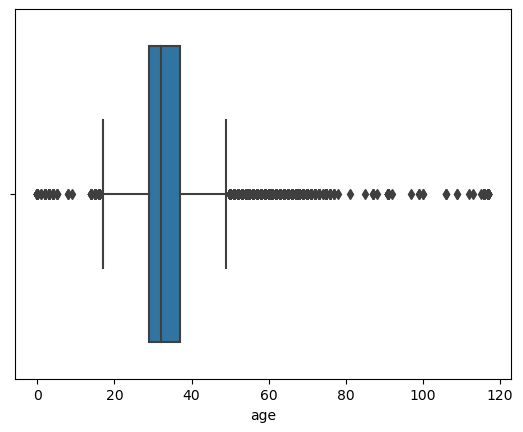

In [26]:
sns.boxplot(df['age'])
plt.show()

- we can observe that there are extreme values at both upper and lower whiskers

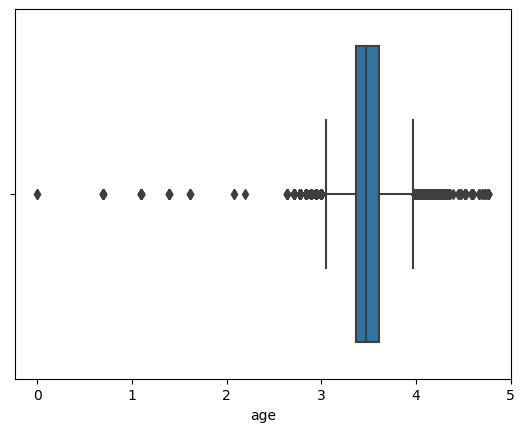

In [27]:
## let use log transformation and transform the column age and visualize the distribution
age_log = np.log(df['age'])
sns.boxplot(age_log)
plt.show()

- we can see that log transformation doesnt remove the age outliers 

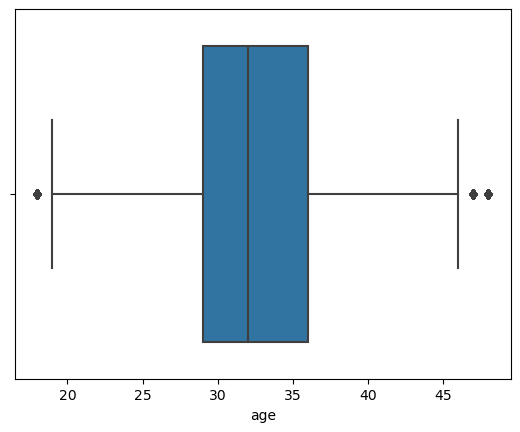

In [28]:
# let us try the IQR method 
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3-Q1
lower_whisker  = Q1-(1.5*IQR)
upper_whisker  = Q3+(1.5*IQR)
df = df.loc[(df['age'] < upper_whisker) & (df['age'] > lower_whisker)]
sns.boxplot(df['age'])
plt.show()

- with the IQR method we are losing around 7% dataset. 

### 11. Check the distribution of the different categories in the column 'rented for' using appropriate plot

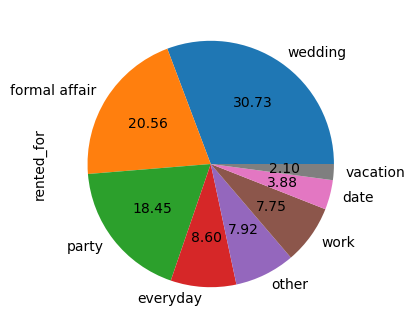

In [29]:
df['rented_for'].value_counts().plot.pie(subplots=True, figsize=(8, 4),autopct="%.2f");

In [30]:
# making a copy of the data so that we can use it for visualization
df1 = df.copy()

## Data Preparation for model building

### 12. Encode the categorical columns 

In [31]:
categorical_columns = ['fit', 'rented_for','body_type','category']
le = LabelEncoder()
for i in categorical_columns:
        df[i] = df[[i]].apply(le.fit_transform)

In [32]:
df.head()

,fit,bust_size,weight,rating,rented_for,body_type,category,height,size,age
0,0,38.0,137.0,10.0,5,3,44,68.0,14,28.0
1,0,36.0,132.0,10.0,3,6,20,66.0,12,36.0
3,0,37.0,135.0,8.0,2,4,16,65.0,8,34.0
4,0,36.0,145.0,10.0,6,1,20,69.0,12,27.0
5,0,34.0,138.0,8.0,0,1,16,68.0,8,45.0


### 13.  Standardize the data, so that the values are within a particular range. 

In [33]:
scaled_features = StandardScaler().fit_transform(df.values)
scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

In [34]:
scaled_features_df.head()

,fit,bust_size,weight,rating,rented_for,body_type,category,height,size,age
0,-0.556711,0.328070,-0.013149,0.636486,0.502585,0.016281,1.578761,1.007464,0.234497,-0.768582
1,-0.556711,-0.529313,-0.262611,0.636486,-0.468224,1.868071,-0.304735,0.257292,-0.003915,0.583413
3,-0.556711,-0.100621,-0.112934,-0.765593,-0.953628,0.633544,-0.618651,-0.117795,-0.480740,0.245414
4,-0.556711,-0.529313,0.385992,0.636486,0.987989,-1.218246,-0.304735,1.382551,-0.003915,-0.937582
5,-0.556711,-1.386695,0.036744,-0.765593,-1.924437,-1.218246,-0.618651,1.007464,-0.480740,2.104408


## Principal Component Analysis and Clustering 

### 14.  Apply PCA on the above dataset and determine the number of PCA components to be used so that 90-95% of the variance in data is explained by the same. 

In [35]:
cov_matrix = np.cov(scaled_features_df.T)

In [36]:
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

In [37]:
total = sum(eig_vals)
var_exp = [ (i/total)*100  for i in sorted(eig_vals,reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print('Variance Explained: ',var_exp)
print('Cummulative Variance Explained: ',cum_var_exp)

Variance Explained:  [25.099217334882688, 12.494380848778064, 10.708271120684774, 10.185365921349172, 9.44070234863869, 8.92446387380603, 8.718731567585257, 7.493482537969657, 4.442344690421893, 2.493039755883772]
Cummulative Variance Explained:  [ 25.09921733  37.59359818  48.3018693   58.48723523  67.92793757
  76.85240145  85.57113302  93.06461555  97.50696024 100.        ]


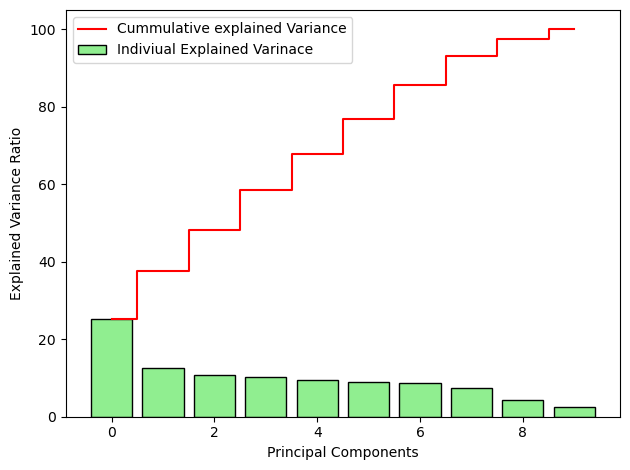

In [38]:
plt.bar(range(10),var_exp, align='center',color='lightgreen',edgecolor='black',label='Indiviual Explained Varinace')
plt.step(range(10), cum_var_exp, where='mid',color='red',label='Cummulative explained Variance')
plt.legend(loc = 'best')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.tight_layout()
plt.show()

Note: from the above diagram we can see that 90-95% of variance is explained by 8 Principal Components

In [39]:
pca=PCA(n_components = 8)
pca.fit(scaled_features_df)

PCA(n_components=8)

In [40]:
data_pca = pca.transform(scaled_features_df)
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'])
data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.394402,-0.893444,0.450482,1.060355,1.498798,0.461784,-0.401128,-0.024147
1,-0.791553,-0.676416,0.430600,-0.312176,-0.989531,1.072094,-1.287098,-0.216508
2,-0.530165,0.211262,0.397266,-0.090144,-1.227465,0.082226,-0.249180,0.879672
3,0.492518,-1.222228,-1.230866,1.109686,0.802150,-1.094902,-0.333829,0.051112
4,-0.057010,0.299688,1.533149,-0.079466,-1.614833,-2.596569,-1.155385,0.423314


### 15. Apply K-means clustering and segment the data (Use Original data or PCA data for clustering)

In [41]:
cluster_range = range(2,15)
cluster_errors = []

for num_clusters in cluster_range:
   
    clusters = KMeans(num_clusters, n_init=10)
    clusters.fit(scaled_features_df)
    
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    
    cluster_errors.append(clusters.inertia_)

clusters_df = pd.DataFrame({'num_clusters':cluster_range, 
                           'cluster_errors':cluster_errors})

clusters_df

,num_clusters,cluster_errors
0,2,1.522351e+06
1,3,1.394309e+06
2,4,1.291567e+06
3,5,1.204112e+06
4,6,1.149305e+06
5,7,1.097669e+06
6,8,1.055193e+06
7,9,1.023782e+06
8,10,9.954164e+05
9,11,9.708274e+05


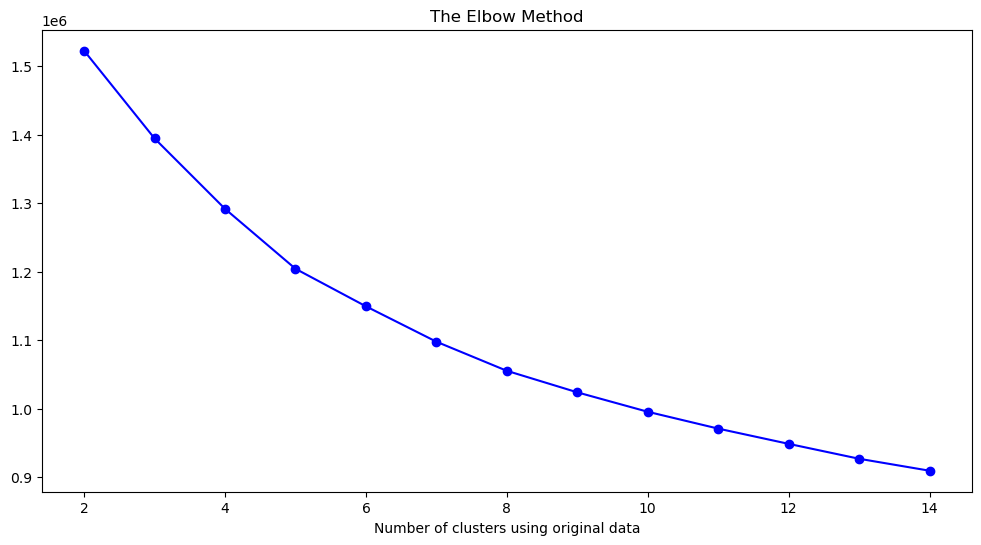

In [42]:
plt.figure(figsize=[12,6])
plt.title('The Elbow Method')
plt.xlabel('Number of clusters using original data')
plt.plot(clusters_df['num_clusters'],clusters_df['cluster_errors'],marker='o',color='b')
plt.show()

- from the above graph we can see that the optimal k value is 3

In [43]:
kmeans = KMeans(n_clusters=3, random_state=105)
cluster_labels = kmeans.fit_predict(scaled_features_df)

In [44]:
print("The silhouette score for 3 clusters is",silhouette_score(scaled_features_df,cluster_labels))

The silhouette score for 3 clusters is 0.1463991295634027


### 16. Apply Agglomerative clustering and segment the data (Use Original data or PCA data for clustering)

In [45]:
sample_df = data_pca.sample(frac = 0.15)

In [46]:
sample_df = sample_df.reset_index(drop = True)

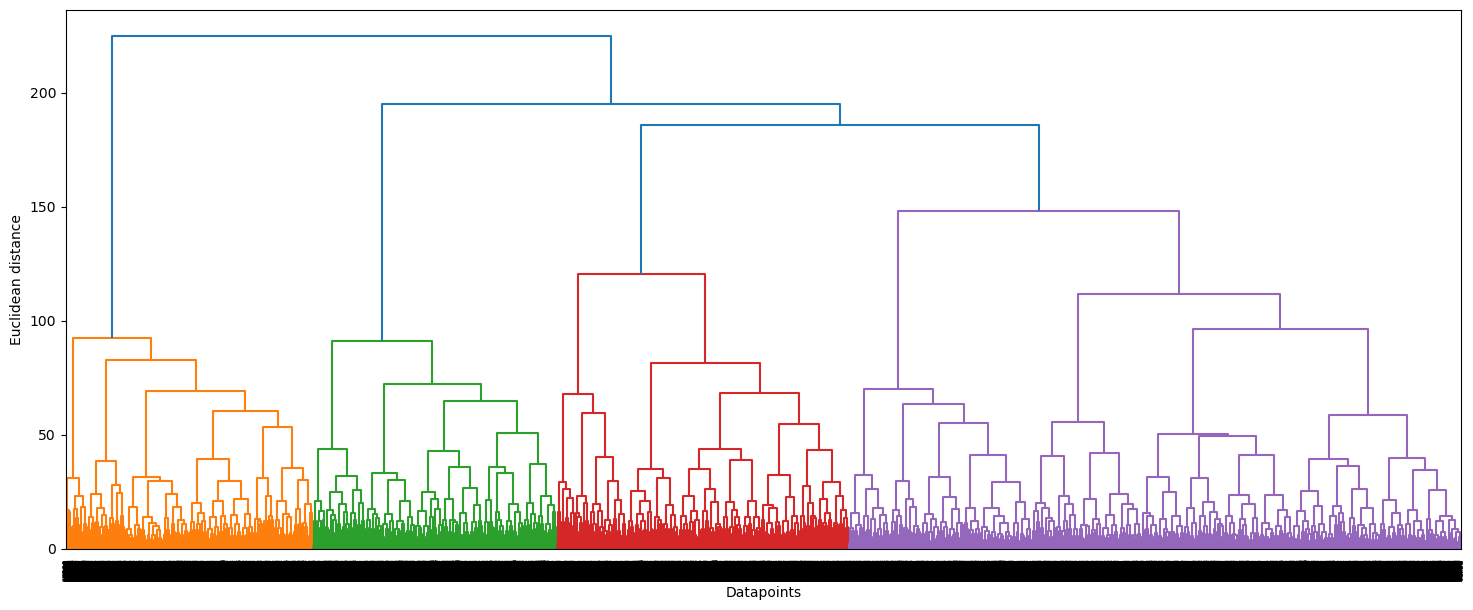

In [47]:
plt.figure(figsize=[18,7])
merg = linkage(sample_df, method='ward')
dendrogram(merg, leaf_rotation=90,)
plt.xlabel('Datapoints')
plt.ylabel('Euclidean distance')
plt.show()

- We can observe from the dendodram and the Silhouette scores for differnt clusters. The highest silhouette score is for 3 clusters.
- so lets choose the number of clusters as 3

In [48]:
hie_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean',
                                     linkage='ward')
hie_cluster_model = hie_cluster.fit(sample_df)

In [49]:
labels = hie_cluster_model.fit_predict(sample_df)
print("The silhouette score for 3 clusters is:",silhouette_score(sample_df,labels))

The silhouette score for 3 clusters is: 0.10938378653882677


### 17.Visualization and Interpretation of results

In [50]:
##In the agglomerative clustering we are using only a fraction of data so it is not a good model to perfrom the Bivariate 
##analysis. Instead we will be using the lables from the kmeans. 
final_df = df1.copy()
final_df['label'] = cluster_labels
final_df.head()

,fit,bust_size,weight,rating,rented_for,body_type,category,height,size,age,label
0,fit,38.0,137.0,10.0,vacation,hourglass,romper,68.0,14,28.0,1
1,fit,36.0,132.0,10.0,other,straight & narrow,gown,66.0,12,36.0,0
3,fit,37.0,135.0,8.0,formal affair,pear,dress,65.0,8,34.0,0
4,fit,36.0,145.0,10.0,wedding,athletic,gown,69.0,12,27.0,1
5,fit,34.0,138.0,8.0,date,athletic,dress,68.0,8,45.0,0


In [51]:
def plot_numerical(feature):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='label', y=feature, data=final_df)
    plt.title(f'{feature} by Cluster')
    plt.show()
    

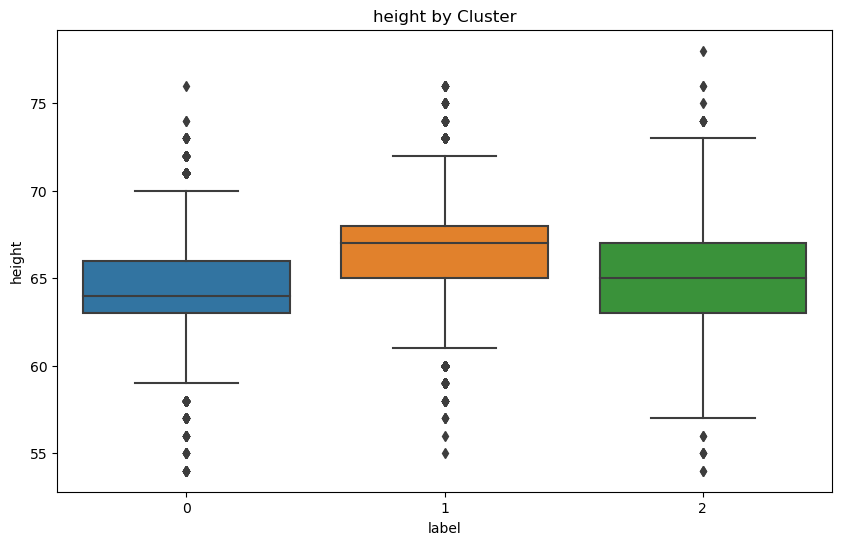

In [52]:
plot_numerical('height')

- the averiage height of cluster 2 is greater than cluster 0 followed by cluster 1

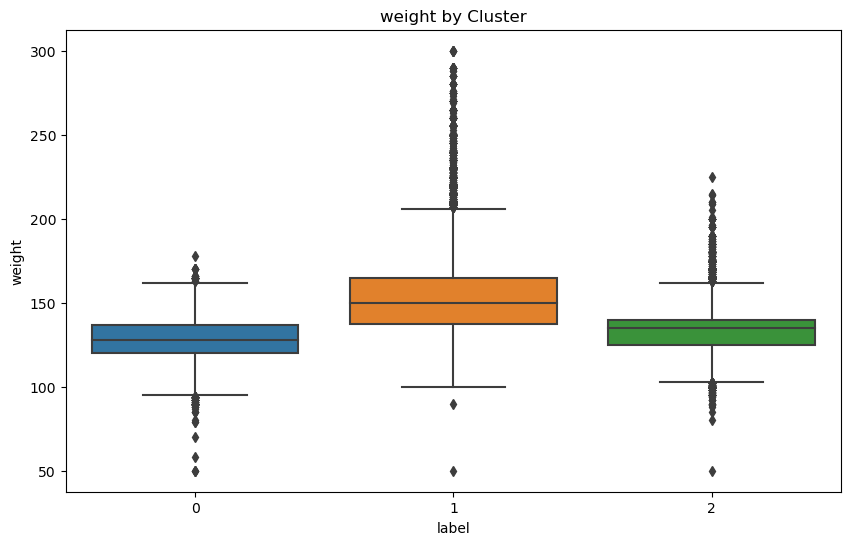

In [53]:
plot_numerical('weight')

- the averiage weight of cluster 2 is greater than cluster 0 followed by cluster 1

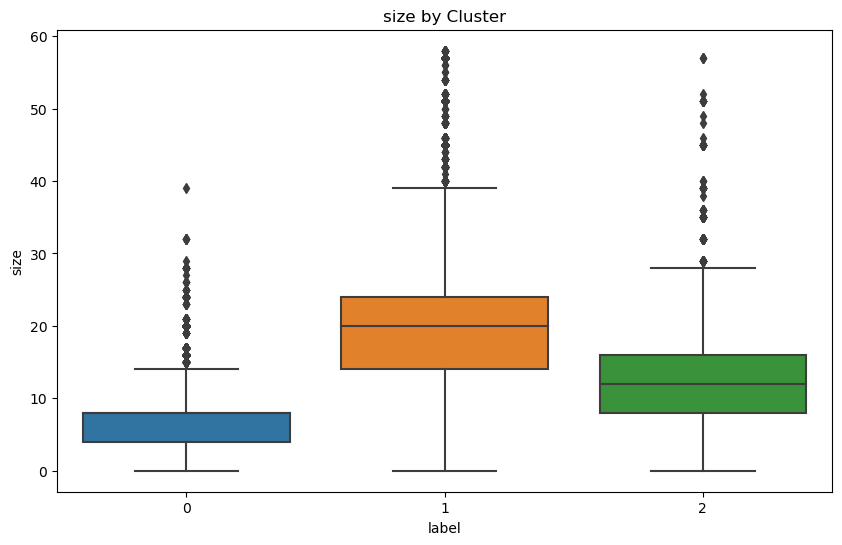

In [54]:
plot_numerical('size')

- the averiage size of cluster 2 is greater than cluster 0 followed by cluster 1

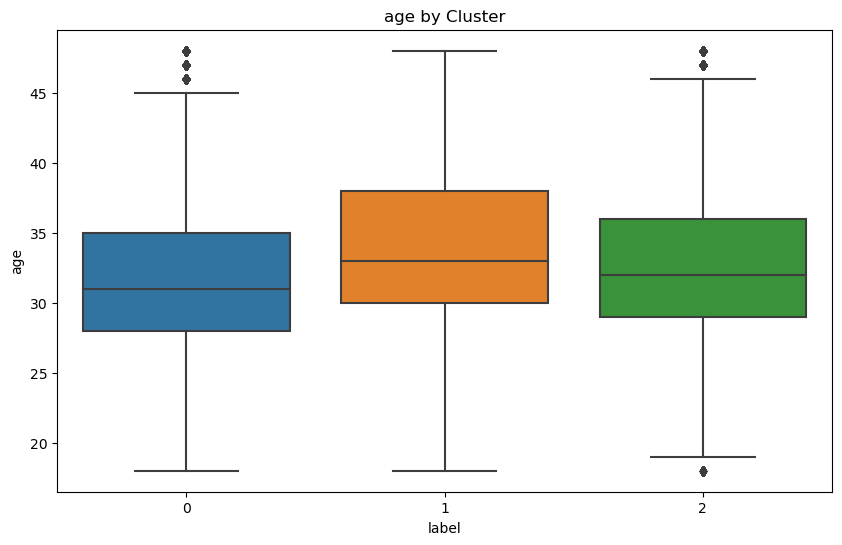

In [55]:
plot_numerical('age')

- the averiage age of cluster 2 is greater than cluster 0 followed by cluster 1

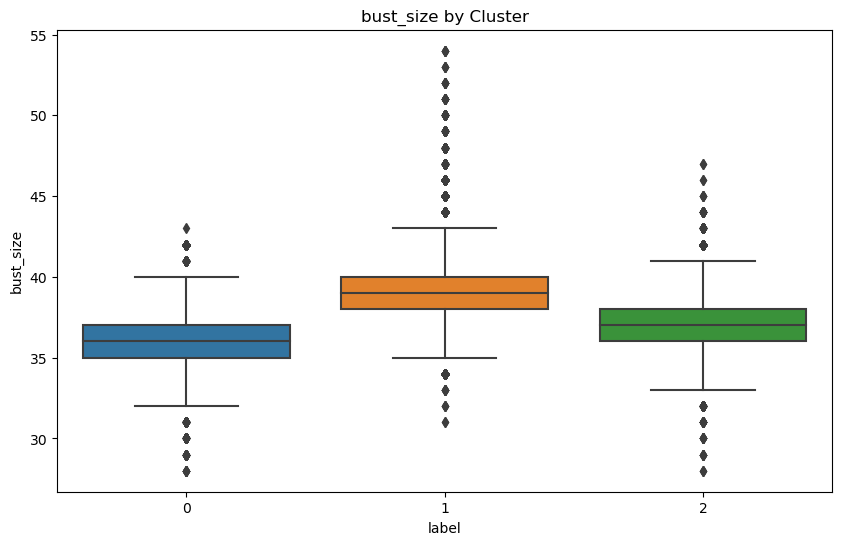

In [56]:
plot_numerical('bust_size')

- the averiage bust_size of cluster 2 is greater than cluster 0 followed by cluster 1

<function matplotlib.pyplot.show(close=None, block=None)>

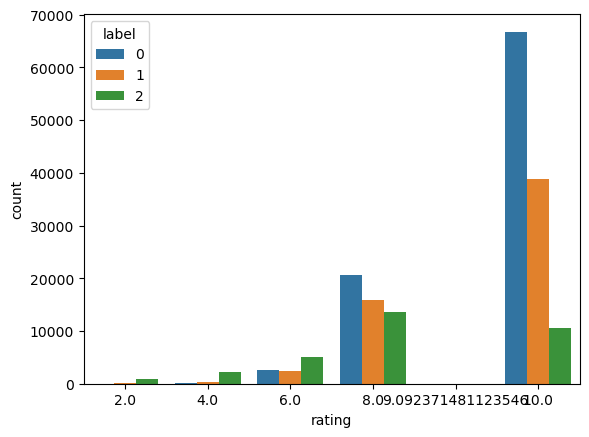

In [57]:
sns.countplot(x='rating',hue = 'label',data = final_df)
plt.show

In [58]:
def plot_categorical(feature):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue='label', data=final_df)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.show()

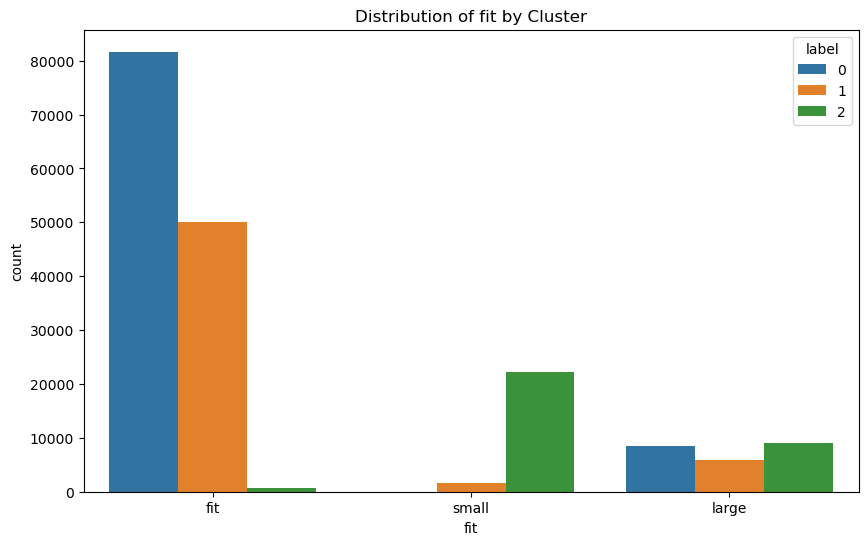

In [59]:
plot_categorical('fit')

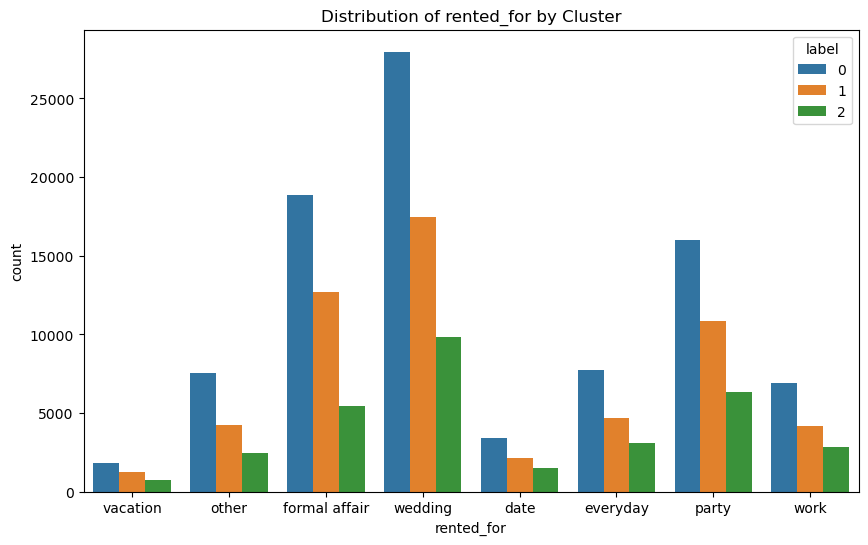

In [60]:
plot_categorical('rented_for')

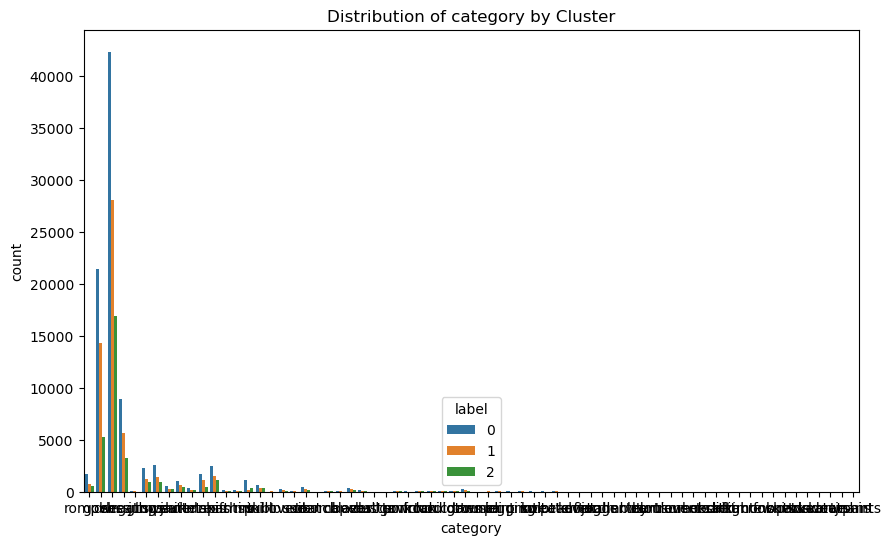

In [61]:
plot_categorical('category')

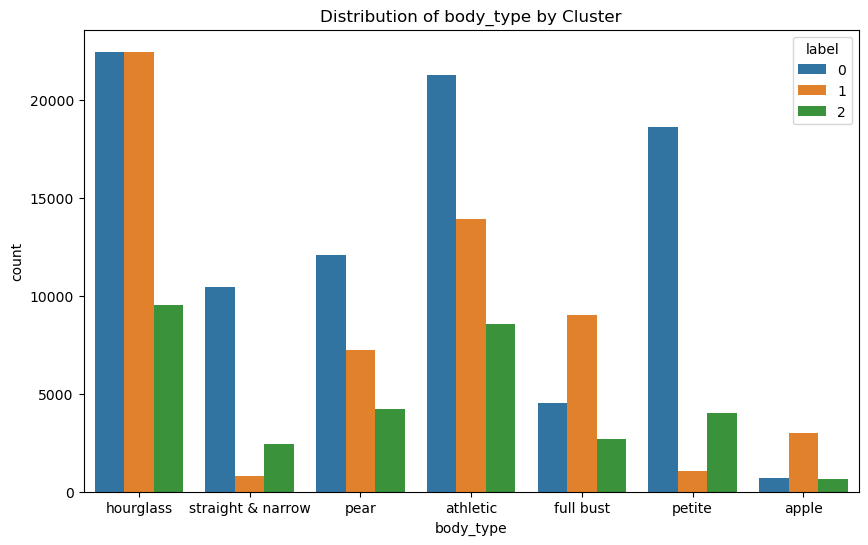

In [62]:
plot_categorical('body_type')

- the total number of purchases is also higher for customers from cluster 0 and then followe by customers of cluster 2

# Conlusion

We can conclude the following about the clusters
- Customers belonging to cluster 2 have 
    - average physical traits
    - spread across all body types
    - least satisified with the product
    - least satisfication with the fit
- Customers belonging to cluster 1 have 
    - highest physical traits 
    - most belong to hourglass body type
    - satisfied with the services. 
    - average satisfaction with the fit
- Customers belonging to cluster 0 have 
    - lowest physical traits 
    - 3 distinct body types hourglass,petite and athelitic
    - moderately satsfied with the services
    - prefer a dresses from a single category
    - mostly satisfied with the fit provided 

# Recommendations

- for cluster 2, launch a special campagin to understand the needs of the customer(like helping to find the best fit) to improve the overall satisfaction
- for cluster 1, promote products that carter to customers with larger body types(promote more products of hour glass shape)
- for cluster 0, create a campagin that promotes the product that they prefer.


-----
## Happy Learning
-----